#### Columnas del dataset

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import ast

from itertools import chain
from collections import Counter
from pandas.io.json import json_normalize
from sklearn import preprocessing

import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATASET = 'dataset/meli_dataset_20190426.csv'

In [3]:
df_raw = pd.read_csv(DATASET, low_memory=False)
df = df_raw.copy()

In [4]:
print(df.shape)
print(df.dtypes)
display(df.sample(5))

(499948, 13)
ITEM_ID                object
SHP_WEIGHT            float64
SHP_LENGTH            float64
SHP_WIDTH             float64
SHP_HEIGHT            float64
ATTRIBUTES             object
CATALOG_PRODUCT_ID     object
CONDITION              object
DOMAIN_ID              object
PRICE                 float64
SELLER_ID              object
STATUS                 object
TITLE                  object
dtype: object


,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
101669,F47SUNIR03,700.0,28.0,19.0,11.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-SOCKS,24.30,NFDVFL8PTR,active,Kit 12 Pares Meia Sortida Cano Alto Longo Spor...
232768,W6INMIERBA,220.0,16.0,11.0,4.0,"[{'id': 'AIRBAG_POSITION', 'name': 'Posição do...",H53U1H7Q5G,new,MLB-AIRBAGS,61.00,ABF5S5J1P7,active,Cinta Fita Airbag Buzina Corolla 2009 2010 201...
297164,EJENSWTLYC,1156.0,25.0,15.0,10.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,DMYSHTESVD,under_review,Localizador De Satélite Antena Satlink Ws6906 ...
150109,AO3VPZ8E2G,NaN,NaN,NaN,NaN,"[{'id': 'BACKPACK_CAPACITY', 'name': 'Capacida...",H53U1H7Q5G,new,MLB-BACKPACKS,49.99,LZ6TRWWZZS,paused,Bolsa Mochila Lona Forrada Camuflada Masculino...
199051,SI8UIFZ080,NaN,NaN,NaN,NaN,"[{'id': 'ALPHANUMERIC_MODEL', 'name': 'Modelo ...",FYO2LFWCEC,new,MLB-TENTS,359.90,UGFT6NH2NH,active,Barraca Iglu Luna 7 Lugares 300 X 3 00 X 180 C...


In [5]:
df.describe()

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE
count,347751.000000,347751.000000,347751.000000,347751.000000,3.685440e+05
mean,1854.789579,31.451148,21.290276,11.578580,1.206323e+03
std,3257.884009,18.339895,11.217308,8.310821,5.018810e+05
min,1.000000,0.000000,0.000000,0.000000,1.000000e-01
25%,260.000000,20.000000,13.000000,5.000000,4.490000e+01
50%,675.000000,25.000000,20.000000,10.000000,9.500000e+01
75%,1900.000000,36.000000,25.000000,16.000000,1.720000e+02
max,50000.000000,288.200000,165.000000,105.000000,3.032487e+08


In [6]:
df.describe(include=['O'])

,ITEM_ID,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,SELLER_ID,STATUS,TITLE
count,499948,368544,499948,368544,367555,421587,499948,421587
unique,384501,245622,15553,3,2853,61781,6,306233
top,EZ118KZWRZ,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-VEHICLE_ACCESSORIES,XYDSNCU3UV,active,Maquininha Point Mini - A Máquina De Cartão Do...
freq,275,16435,450354,365978,9100,842,226459,297


* Se verifican valores nulos

In [7]:
df.isna().sum()

ITEM_ID                    0
SHP_WEIGHT            152197
SHP_LENGTH            152197
SHP_WIDTH             152197
SHP_HEIGHT            152197
ATTRIBUTES            131404
CATALOG_PRODUCT_ID         0
CONDITION             131404
DOMAIN_ID             132393
PRICE                 131404
SELLER_ID              78361
STATUS                     0
TITLE                  78361
dtype: int64

1. Eliminar valores cuyo status sea `404` , luego eliminar la columna `status` del dataset ya que solo es útil para limpieza.

In [8]:
df.STATUS.value_counts()

active          226459
paused          115937
404              78361
under_review     47986
closed           26416
inactive          4789
Name: STATUS, dtype: int64

In [9]:
df_st404=df[ df.STATUS == '404' ]
df.drop(df_st404.index, axis=0, inplace=True)
print(df_st404.shape)
print(df.shape)

(78361, 13)
(421587, 13)


In [10]:
df.STATUS.value_counts()

active          226459
paused          115937
under_review     47986
closed           26416
inactive          4789
Name: STATUS, dtype: int64

In [11]:
df.describe()

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE
count,296325.000000,296325.000000,296325.000000,296325.000000,3.685440e+05
mean,1861.113376,31.425418,21.318047,11.562349,1.206323e+03
std,3254.648188,18.619009,11.301308,8.358276,5.018810e+05
min,1.000000,0.000000,0.000000,0.000000,1.000000e-01
25%,253.000000,20.000000,13.000000,5.000000,4.490000e+01
50%,680.000000,25.000000,20.000000,10.000000,9.500000e+01
75%,1948.000000,36.000000,25.000000,16.000000,1.720000e+02
max,50000.000000,288.200000,165.000000,105.000000,3.032487e+08


2. Eliminar los valores NaN de las columnas con prefijo `SHP_`. Estas son aquellas que representan o peso o dimensiones de un item.

In [12]:
#Igual .AND. y .OR.

In [13]:
df[ (df.SHP_WEIGHT.notna()) & (df.SHP_LENGTH.notna()) & (df.SHP_WIDTH.notna()) & (df.SHP_HEIGHT.notna()) ]['ITEM_ID'].count()

296325

In [14]:
df[ (df.SHP_WEIGHT.notna()) | (df.SHP_LENGTH.notna()) | (df.SHP_WIDTH.notna()) | (df.SHP_HEIGHT.notna()) ]['ITEM_ID'].count()

296325

In [15]:
df_SHPNA = df[ (df.SHP_WEIGHT.isna()) ]
df.drop(df_SHPNA.index, axis=0, inplace=True)
print(df_SHPNA.shape)
print(df.shape)

(125262, 13)
(296325, 13)


In [16]:
df.describe()

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE
count,296325.000000,296325.000000,296325.000000,296325.000000,2.619580e+05
mean,1861.113376,31.425418,21.318047,11.562349,1.610124e+03
std,3254.648188,18.619009,11.301308,8.358276,5.952876e+05
min,1.000000,0.000000,0.000000,0.000000,1.000000e-01
25%,253.000000,20.000000,13.000000,5.000000,4.890000e+01
50%,680.000000,25.000000,20.000000,10.000000,1.000000e+02
75%,1948.000000,36.000000,25.000000,16.000000,1.790000e+02
max,50000.000000,288.200000,165.000000,105.000000,3.032487e+08


In [17]:
df.describe(include=['O'])

,ITEM_ID,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,SELLER_ID,STATUS,TITLE
count,296325,261958,296325,261958,261273,296325,296325,296325
unique,236443,186035,12919,3,2763,52437,5,228375
top,EZ118KZWRZ,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-VEHICLE_ACCESSORIES,FPP4RBSNBJ,active,Maquininha Point Mini - A Máquina De Cartão Do...
freq,161,11788,261263,260579,6856,667,161502,164


3.Agrupar por item id y calcular mediana de peso y medidas. De esta forma debería quedar una única fila por cada item_id.

In [18]:
df.ITEM_ID.value_counts().count()

236443

In [19]:
df[ df.ITEM_ID=='Q2JN7G81QD']

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
374879,Q2JN7G81QD,580.0,16.0,11.0,4.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PERFUMES,119.99,Z65X9XQP8X,active,Combo Amadeirado Natura | Essencial - Horus E ...
374880,Q2JN7G81QD,775.0,25.0,11.0,5.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PERFUMES,119.99,Z65X9XQP8X,active,Combo Amadeirado Natura | Essencial - Horus E ...


In [20]:
df_item=df.pivot_table(index='ITEM_ID', 
                       values=['SHP_WEIGHT','SHP_LENGTH','SHP_WIDTH','SHP_HEIGHT','PRICE'], 
                       aggfunc='median')
df_item_avgp=df.pivot_table(index='ITEM_ID', values='PRICE', aggfunc='mean')
df_item_avgp.columns=['PRICE_AVG']
df_item_cant=df.pivot_table(index='ITEM_ID', values='SHP_WEIGHT', aggfunc='count')
df_item_cant.columns=['ITEM_COUNT']

print(df_item.shape)
display(df_item.sample(3))
print(df_item_avgp.shape)
display(df_item_avgp.sample(3))
print(df_item_cant.shape)
display(df_item_cant.sample(3))

(236443, 5)


,PRICE,SHP_HEIGHT,SHP_LENGTH,SHP_WEIGHT,SHP_WIDTH
ITEM_ID,,,,,
NPGCS18OEP,45.00,20.0,25.0,1909.0,25.0
Y545E5NMDV,25.00,10.0,28.0,200.0,18.0
EDV3GQGUYK,85.95,11.0,30.0,2990.0,16.0


(210659, 1)


,PRICE_AVG
ITEM_ID,
Z93OFI7ANR,145.0
K3ZNTKU9IX,198.0
AWUGY02B1L,220.0


(236443, 1)


,ITEM_COUNT
ITEM_ID,
LYT42QM3ZG,1
FH01HSS0VF,1
QFP76P1GOF,1


In [21]:
df_item=pd.merge(left=df_item, right=df_item_avgp, how='left', left_on='ITEM_ID', right_on='ITEM_ID', right_index=True)
df_item=pd.merge(left=df_item, right=df_item_cant, how='left', left_on='ITEM_ID', right_on='ITEM_ID', right_index=True)
df_item=df_item.reset_index()

In [22]:
print(df_item.shape)
display(df_item.sample(5))
display(df_item.describe())

(236443, 8)


,ITEM_ID,PRICE,SHP_HEIGHT,SHP_LENGTH,SHP_WEIGHT,SHP_WIDTH,PRICE_AVG,ITEM_COUNT
40993,EIAO0QXGEJ,79.90,2.0,20.0,178.0,15.0,79.90,1
148027,Q9B8BZGOZT,NaN,5.0,25.0,1700.0,11.0,NaN,1
186869,UJU53NA6YY,149.90,17.5,37.0,2840.0,32.5,149.90,2
137000,P1SW1NEGY8,119.49,16.0,26.0,159.5,16.0,119.49,10
192454,V60DOOQXKN,299.99,20.0,30.0,3600.0,30.0,299.99,1


,PRICE,SHP_HEIGHT,SHP_LENGTH,SHP_WEIGHT,SHP_WIDTH,PRICE_AVG,ITEM_COUNT
count,2.106590e+05,236443.000000,236443.000000,236443.00000,236443.000000,2.106590e+05,236443.000000
mean,1.958341e+03,11.503536,31.398151,1818.96622,21.251572,1.958341e+03,1.253262
std,6.638232e+05,8.234870,18.469790,3199.67595,11.157975,6.638232e+05,1.103542
min,1.000000e-01,0.000000,0.000000,1.00000,0.000000,1.000000e-01,1.000000
25%,4.790000e+01,5.000000,20.000000,250.00000,13.000000,4.790000e+01,1.000000
50%,9.999000e+01,10.000000,25.000000,650.00000,20.000000,9.999000e+01,1.000000
75%,1.799000e+02,16.000000,36.000000,1883.75000,25.000000,1.799000e+02,1.000000
max,3.032487e+08,105.000000,288.200000,50000.00000,115.000000,3.032487e+08,161.000000


In [23]:
del df_item_cant
del df_item_avgp

Se agruparon los envíos por ITEM calculando 236443 diferentes con sus medianas de peso y dimensiones. Decidimos para el resto del trabajo utilizar el dataset completo y no este reducido por considerar que pederíamos características de envíos que faltaría en esta tabla por item.

In [25]:
df_item.to_csv('dataset/meli_dataset_a_xitem.csv')

4. Parsear la columna de atributos y extraer a columnas propias aquellos atributos cuyo `id` sea `BRAND` o `MODEL`. Estos atributos representan marca o modelo que el vendedor del item ingresó en la publicación. [Opcional] No es necesario limitarse a estos dos atributos, se puede probar quedarse con los N atributos más frecuentes.

In [26]:
def convert_json(x):
    if type(x)==str:
        return ast.literal_eval(x)
    else: 
        return np.nan

df['ATR']=df.ATTRIBUTES.apply(convert_json)

In [27]:
df['LEN_ATR']=df.ATR.apply(lambda x: len(x) if type(x)==list else 0)
df['ATR_ID'] =df.ATR.apply(lambda x: [d.get('id') for d in x] if type(x)==list else '')

In [28]:
df[['ATTRIBUTES','ATR','LEN_ATR','ATR_ID']].head(5)

,ATTRIBUTES,ATR,LEN_ATR,ATR_ID
1,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",6,"[BRAND, GTIN, ITEM_CONDITION, LINE, MODEL, SKI..."
2,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...","[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",9,"[ACCESSORIES_INCLUDED, BRAND, EAN, GTIN, ITEM_..."
3,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...","[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",9,"[ACCESSORIES_INCLUDED, BRAND, EAN, GTIN, ITEM_..."
5,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...","[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",9,"[ACCESSORIES_INCLUDED, BRAND, EAN, GTIN, ITEM_..."
7,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...","[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",9,"[ACCESSORIES_INCLUDED, BRAND, EAN, GTIN, ITEM_..."


In [29]:
lst_atr=list(chain(*np.array(df.ATR_ID)))
set_atr=set(lst_atr)
df_atr=pd.DataFrame(data=lst_atr, columns=['ATTRIBUTE'])

In [30]:
df_atr.sample(5)

,ATTRIBUTE
1185703,BRAND
1846823,INCLUDES_PILLOWCASES
11866,CHARACTER_VERSION
271083,UNIT_WEIGHT
2319133,ORIGIN


In [31]:
print(len(set_atr))
display(df_atr.ATTRIBUTE.value_counts().head(6))

7301


ITEM_CONDITION    261248
BRAND             235321
MODEL             192206
GTIN               97921
EAN                60846
SELLER_SKU         47730
Name: ATTRIBUTE, dtype: int64

#### Vamos a extraer BRAND y MODEL, el resto de los atributos que mas se repiten ya están en una columna (ITEM_CONDITION) o carecen de significado.

In [32]:
df['ATR_BRAND'] =df.ATR.apply(lambda x: [d.get('value_name') for d in x if d.get('id')=='BRAND'] if type(x)==list else '')
df['ATR_MODEL'] =df.ATR.apply(lambda x: [d.get('value_name') for d in x if d.get('id')=='MODEL'] if type(x)==list else '')
df['ATR_CONDITION'] =df.ATR.apply(lambda x: [d.get('value_name') for d in x if d.get('id')=='ITEM_CONDITION'] 
                                  if type(x)==list else '')

In [33]:
df.ATR_BRAND =df.ATR_BRAND.apply(lambda x: x[0] if len(x)>0 else np.nan)
df.ATR_MODEL =df.ATR_MODEL.apply(lambda x: x[0] if len(x)>0 else np.nan)
df.ATR_CONDITION =df.ATR_CONDITION.apply(lambda x: x[0] if len(x)>0 else np.nan)

In [34]:
df[['ATTRIBUTES','ATR','LEN_ATR','ATR_ID','ATR_BRAND','ATR_MODEL']].sample(5)

,ATTRIBUTES,ATR,LEN_ATR,ATR_ID,ATR_BRAND,ATR_MODEL
461097,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",12,"[BRAND, CHARACTER, CHARACTER_VERSION, DOLL_TYP...",Carrinho de Boneca Apollo,NaN
429147,"[{'id': 'BRAND', 'name': 'Marca do cabo', 'val...","[{'id': 'BRAND', 'name': 'Marca do cabo', 'val...",7,"[BRAND, CABLE_LENGTH, COMPATIBILITY, INPUT_CON...",Multilaser,Original+
122324,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",4,"[BRAND, GENDER, ITEM_CONDITION, MODEL]",Kode,F3 noban
283994,"[{'id': 'ACCESSORY_TYPE', 'name': 'Tipo de ace...","[{'id': 'ACCESSORY_TYPE', 'name': 'Tipo de ace...",5,"[ACCESSORY_TYPE, BRAND, GTIN, ITEM_CONDITION, ...",PROMAR,NaN
279324,"[{'id': 'ACCESSORIES_NUMBER', 'name': 'Quantid...","[{'id': 'ACCESSORIES_NUMBER', 'name': 'Quantid...",14,"[ACCESSORIES_NUMBER, BATTERY_VOLTAGE, BRAND, D...",Belfix,231500


#### Por curiosidad, hacemos un muestreo de los valores de Condición del JSON contra lo que muestra la columna

In [35]:
df[['CONDITION','ATR_CONDITION']].describe()

,CONDITION,ATR_CONDITION
count,261958,261248
unique,3,6
top,new,Novo
freq,260579,260103


In [36]:
df.ATR_CONDITION.value_counts()

Novo               260103
Usado                 997
2230284               115
Recondicionado         26
Reacondicionado         4
Seminovo                3
Name: ATR_CONDITION, dtype: int64

#### Miramos también los valores de Marca y Modelo, observando que muestran descripciones SIN normalizar

In [37]:
print(df.ATR_BRAND.value_counts().count())
df.ATR_BRAND.value_counts().head(10)

42387


Importado     6272
Samsung       2927
Volkswagen    1717
Motorola      1668
LG            1657
Chevrolet     1452
Apple         1326
Sony          1232
Fiat          1082
HP            1073
Name: ATR_BRAND, dtype: int64

In [38]:
df[ (df.ATR_BRAND.isna()) ].sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE,ATR,LEN_ATR,ATR_ID,ATR_BRAND,ATR_MODEL,ATR_CONDITION
235816,G1OBQOH9M8,600.0,20.0,16.0,11.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BEAUTY_AND_PERSONAL_CARE_SUPPLIES,65.3,KSFI8GZO8K,active,Kit 10 Cartuchos P/ Dermapen 9 Ou 12 Ou 36 Ou...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",5,"[BRAND, ITEM_CONDITION, LINE, MODEL, SKIN_CARE...",None,None,Novo
286274,QOZ2TDDCVK,100.0,25.0,11.0,5.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,MR934072HU,under_review,Bateria Bl-46zh Lg K7 K8 2045mha Original Nova,NaN,0,,NaN,NaN,NaN
281674,VLL2EI7TKC,500.0,25.0,25.0,10.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,C0UTATRD0J,under_review,Nicer Dicer Plus Descascador Cortador Fatiador...,NaN,0,,NaN,NaN,NaN
137081,RRCLPKO4J7,2980.0,51.0,36.0,16.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,G6SINVIYLC,under_review,50 Tubetes 50 Latinhas Metal 50 Caixinhas 5x5 ...,NaN,0,,NaN,NaN,NaN
262615,KTGRKOV0IT,2230.0,41.0,35.0,30.0,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,205.0,Y8C3RWELPN,paused,Kit Pelicula E Pressure 8112 + Toner 8112,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",1,[ITEM_CONDITION],NaN,NaN,Novo


In [39]:
df[ (df.ATR_BRAND.str.contains('nal Volk')) | (df.ATR_BRAND.str.contains('nal Volk')) ].sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE,ATR,LEN_ATR,ATR_ID,ATR_BRAND,ATR_MODEL,ATR_CONDITION
125186,NG77D2GEX5,200.0,16.0,11.0,2.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-VEHICLE_PARTS,109.09,OI28SZV7FV,active,Cinta Do Airbag Amarok Fox Gol Saveiro Up Voya...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",5,"[BRAND, ITEM_CONDITION, PART_NUMBER, PART_TYPE...",Original Volkswagen,NaN,Novo
174811,W4PVUGS1S8,500.0,16.0,11.0,4.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-VEHICLE_ACCESSORIES,37.00,I8F1AH6MBL,active,Kit Coifa + Bola Cambio Gol Quadrado Parati Sa...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",2,"[BRAND, ITEM_CONDITION]",Nacional Volkswagen,NaN,Novo
56369,GS3BXERC1F,2255.0,56.0,35.0,22.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-VEHICLE_PARTS,168.00,P82PHAO8M1,active,Par Ponteira Do Parachoque Traseiro Saveiro 93...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",4,"[BRAND, ITEM_CONDITION, PART_NUMBER, SELLER_SKU]",Original Volkswagen,NaN,Novo
36574,P7HX5Y5CHM,300.0,25.0,20.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-VEHICLE_PARTS,100.00,P82PHAO8M1,paused,Motor Trava Elétrica Porta Malas Gol G3 00 A 0...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",2,"[BRAND, ITEM_CONDITION]",Original Volkswagen,NaN,Novo
79999,OVJ00ZHNA9,610.0,21.0,16.0,6.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-SPARK_PLUG_WIRESETS,147.00,JVEWNC635O,active,Jogo Velas Originais Cabos Premium Fox 1.0 E 1...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",11,"[BRAND, EAN, GTIN, ITEM_CONDITION, MODEL, MPN,...",Original Volkswagen / Perfect,Gol G4 G5,Novo


In [40]:
df[ (df.ATR_BRAND.str.contains('wagen')) | (df.ATR_BRAND.str.contains('WAGEN')) ].ATR_BRAND.value_counts()

Volkswagen                                                                  1717
volkswagen                                                                    24
VOLKSWAGEN                                                                    22
Original Volkswagen                                                            9
ORIGINAL VOLKSWAGEN                                                            3
ORIGINAL - VOLKSWAGEN                                                          2
Nacional Volkswagen                                                            2
Emblema Volkwagen                                                              2
BMW Mercedes Benz Audi Porsche Volkswagen Chevrolet Hyundai Honda Toyota       2
Volkswagen Trw                                                                 2
Original Volkswagen / Perfect                                                  1
VW VOLKSWAGEN                                                                  1
wolkswagen                  

#### Revisión de Atributos

In [41]:
#Definimos nuestra variable objetivo
print(df[ df.SHP_LENGTH >= df.SHP_WIDTH ].SHP_LENGTH.count())
print(df[ df.SHP_LENGTH >= df.SHP_HEIGHT ].SHP_LENGTH.count())

296325
296325


In [42]:
df['EXCEDIDO'] = df.SHP_LENGTH.apply(lambda x: 1 if x > 70 else 0)
df[  ['SHP_LENGTH','EXCEDIDO'] ].sample(5)

,SHP_LENGTH,EXCEDIDO
414053,16.0,0
176244,38.0,0
366278,20.0,0
238376,47.0,0
200196,30.0,0


In [43]:
print(df.EXCEDIDO.value_counts())
print(df.EXCEDIDO.value_counts(normalize=True))

0    283014
1     13311
Name: EXCEDIDO, dtype: int64
0    0.95508
1    0.04492
Name: EXCEDIDO, dtype: float64


#### La clase objetivo está desbalanceada, solo el 4% excede el tope impuesto por el correo

In [44]:
#Agrupación de categorías con poca significacncia
cat_resto='OTROS'
cat_SINDT='SIN_DATOS'

#### Las categorizaciones con valores nulos las vamos a asignar a un label "SIN_DATOS", ya que asumimos que es una situación que pueda darse al no ser valores obligatorios.
#### Las categorizaciones con menos de 30 valores las consideramos sin valor estadístico, por lo tanto las agrupamos con el label "OTROS"

In [45]:
def aColumna(col, acol, mnmo=30):
    
    #Cantidad de Envios x Atributo
    dcol=df[col].value_counts()
    categorias=dcol.shape[0]
    
    #Mantenemos aquellos con al menos 30 envíos
    validos=dcol[ dcol>=mnmo ]
    rmplz=dcol[ dcol<mnmo ]

    df[acol]=df[col]
    df[acol]=np.where(df[acol].isin(rmplz.index), cat_resto, df[col])

    #Valores Nulos
    nulos=df[ df[acol].isna() ].ITEM_ID.count()
    if nulos>0:
        df[acol].fillna(cat_SINDT, inplace=True)

    envios_otros=df[ df[acol]==cat_resto ][acol].count()   
    envios_sindt=df[ df[acol]==cat_SINDT ][acol].count() 
        
    print('Atributo:', col)
    print('Cantegorias:', categorias)
    print('CAT >=',mnmo,' Envios:', validos.shape[0], ' Atrib -Total Envíos:', 
                              validos.sum(), '-', validos.sum()/df.shape[0], '%' )
    print('CAT < ',mnmo,' Envios:', rmplz.shape[0]  , ' Atrib -Total Envíos:',
                              rmplz.sum(), '-', rmplz.sum()/df.shape[0], '% >> '+cat_resto)
    print('Envios SIN CAT:', nulos,'--', nulos/df.shape[0], '% >> '+ cat_SINDT)
    print('>> A '+cat_resto+':', envios_otros, '--', envios_otros/df.shape[0], '%')
    print('>> A '+cat_SINDT+':', envios_sindt, '--', envios_otros/df.shape[0], '%')
   
    print('-'*10)
    print('Describe >=', mnmo)
    display(validos.describe())
    
    dc=pd.crosstab(index=df[acol], columns=df.EXCEDIDO)
    dc.reset_index(inplace=True)
    dc.sort_values(1, ascending=False, inplace=True)
    print('-'*10)
    print('CAT más importantes')
    display(dc.sort_values(0, ascending=False).head(5)) 
    print('-'*10)
    print('CAT con Envíos EXCEDIDOS')
    display(dc[ dc[1]>0 ].head(10))  
    print('-'*10)
    display(df[acol].value_counts(normalize=True).head(5))
    print(':'*30)


In [46]:
#Analizamos Catalogo
#Agrupamos las categorías con envíos menores a 30 por poca significancia estadística. Se junta en la categoría OTROS.
#Vemos que esta categoría OTROS tiene un peso importante en la distribución, siendo la segunda en importancia.
aColumna('CATALOG_PRODUCT_ID','DT_CAT_PROD',30)

Atributo: CATALOG_PRODUCT_ID
Cantegorias: 12919
CAT >= 30  Envios: 83  Atrib -Total Envíos: 265575 - 0.8962288028347254 %
CAT <  30  Envios: 12836  Atrib -Total Envíos: 30750 - 0.10377119716527461 % >> OTROS
Envios SIN CAT: 0 -- 0.0 % >> SIN_DATOS
>> A OTROS: 30750 -- 0.10377119716527461 %
>> A SIN_DATOS: 0 -- 0.10377119716527461 %
----------
Describe >= 30


count        83.000000
mean       3199.698795
std       28671.590102
min          30.000000
25%          35.000000
50%          44.000000
75%          59.000000
max      261263.000000
Name: CATALOG_PRODUCT_ID, dtype: float64

----------
CAT más importantes


EXCEDIDO,DT_CAT_PROD,0,1
15,H53U1H7Q5G,249434,11829
47,OTROS,29355,1395
67,V6IPG9TCA6,319,0
61,SYI3HG2NMI,154,1
59,SSGMBJW6W4,101,0


----------
CAT con Envíos EXCEDIDOS


EXCEDIDO,DT_CAT_PROD,0,1
15,H53U1H7Q5G,249434,11829
47,OTROS,29355,1395
54,QRV2NUP5Q6,0,38
60,SVVGHXQI35,8,22
51,Q3YRFEKULF,25,11
35,LOH21IOB8H,57,6
73,W5WNI9W3MD,65,3
52,Q86F9FZDDB,44,1
17,HELRXK5FCC,57,1
69,VIQBB4LQZG,66,1


----------


H53U1H7Q5G    0.881677
OTROS         0.103771
V6IPG9TCA6    0.001077
SYI3HG2NMI    0.000523
SSGMBJW6W4    0.000341
Name: DT_CAT_PROD, dtype: float64

::::::::::::::::::::::::::::::


In [47]:
df[ df.CATALOG_PRODUCT_ID =='H53U1H7Q5G'].sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,...,STATUS,TITLE,ATR,LEN_ATR,ATR_ID,ATR_BRAND,ATR_MODEL,ATR_CONDITION,EXCEDIDO,DT_CAT_PROD
460452,BVEPPW28DN,300.0,23.0,13.0,6.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-TOOLS,159.49,...,active,Termômetro Digital Infravermelho Laser 580° Mi...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",6,"[BRAND, GTIN, ITEM_CONDITION, MODEL, SELLER_SK...",MINIPA,MT-320a,Novo,0,H53U1H7Q5G
376948,O52QM2XD2E,805.0,37.0,25.0,15.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,...,under_review,Puma Rihanna Fenty Veludopromoção 15 Primeiras...,NaN,0,,NaN,NaN,NaN,0,H53U1H7Q5G
83527,JXY7GJ1GOZ,330.0,16.0,11.0,9.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-MOTORCYCLE_LEVERS,164.79,...,active,Manete Esportivo Hornet Dobravel 08-14 Spencer...,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",7,"[BRAND, ITEM_CONDITION, LENGTH, ORIGIN, PART_N...",Spencer,NaN,Novo,0,H53U1H7Q5G
390094,TOVCAKBFQT,970.0,40.0,30.0,15.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-SPEAKERS,120.00,...,closed,Caixa De Som Charge 4 + Carregador Turbo Samsung,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",7,"[BRAND, DIMENSIONS, IS_PORTABLE, ITEM_CONDITIO...",Samsung,Charge 4,Novo,0,H53U1H7Q5G
82396,N91IUTO0ZZ,425.0,16.0,12.0,11.0,"[{'id': 'BOARD_CODE', 'name': 'Código da placa...",H53U1H7Q5G,new,MLB-TV_SMPS,218.99,...,paused,Placa Mãe Notebook Cce Ultra Thin U25 U45l 71r...,"[{'id': 'BOARD_CODE', 'name': 'Código da placa...",8,"[BOARD_CODE, BRAND, COMPATIBLE_TV_MODEL, EAN, ...",CCE,71r-c14cu4-t810,Novo,0,H53U1H7Q5G


#### Consideraciones:
* Hay un catálogo asignado al 88% de los envíos.
* Agrupamos los catálogos en pocos envíos (30) en uno solo, OTROS, que representa el 10% de los envíos y mantiene la misma proporción de Excedidos que el catálogo mayoritario.
* Dejamos el resto de los catálogos con mayor a 30 envíos ya que tienen diferente comportamiento sobre la variable Excedido y podrían mejorar la estimación.

In [48]:
#Analizamos Condición de Venta
aColumna('CONDITION','DT_CONDITION',30)

Atributo: CONDITION
Cantegorias: 3
CAT >= 30  Envios: 3  Atrib -Total Envíos: 261958 - 0.8840226103096263 %
CAT <  30  Envios: 0  Atrib -Total Envíos: 0 - 0.0 % >> OTROS
Envios SIN CAT: 34367 -- 0.11597738969037374 % >> SIN_DATOS
>> A OTROS: 0 -- 0.0 %
>> A SIN_DATOS: 34367 -- 0.0 %
----------
Describe >= 30


count         3.000000
mean      87319.333333
std      150047.643408
min         356.000000
25%         689.500000
50%        1023.000000
75%      130801.000000
max      260579.000000
Name: CONDITION, dtype: float64

----------
CAT más importantes


EXCEDIDO,DT_CONDITION,0,1
1,new,248072,12507
0,SIN_DATOS,33601,766
3,used,991,32
2,not_specified,350,6


----------
CAT con Envíos EXCEDIDOS


EXCEDIDO,DT_CONDITION,0,1
1,new,248072,12507
0,SIN_DATOS,33601,766
3,used,991,32
2,not_specified,350,6


----------


new              0.879369
SIN_DATOS        0.115977
used             0.003452
not_specified    0.001201
Name: DT_CONDITION, dtype: float64

::::::::::::::::::::::::::::::


#### Condición de Venta
* Cerca del 90% son Nuevos
* Es raro que exista muy poca cantidad de usados

In [49]:
#Analizamos Dominio
aColumna('DOMAIN_ID','DT_DOMAIN',30)

Atributo: DOMAIN_ID
Cantegorias: 2763
CAT >= 30  Envios: 1090  Atrib -Total Envíos: 247058 - 0.8337399814392981 %
CAT <  30  Envios: 1673  Atrib -Total Envíos: 14215 - 0.047970977811524505 % >> OTROS
Envios SIN CAT: 35052 -- 0.11828904074917743 % >> SIN_DATOS
>> A OTROS: 14215 -- 0.047970977811524505 %
>> A SIN_DATOS: 35052 -- 0.047970977811524505 %
----------
Describe >= 30


count    1090.000000
mean      226.658716
std       463.932155
min        30.000000
25%        51.000000
50%        93.000000
75%       209.000000
max      6856.000000
Name: DOMAIN_ID, dtype: float64

----------
CAT más importantes


EXCEDIDO,DT_DOMAIN,0,1
1091,SIN_DATOS,34225,827
1090,OTROS,13244,971
1029,MLB-VEHICLE_ACCESSORIES,6473,383
957,MLB-SUPPLEMENTS,5700,80
1035,MLB-VEHICLE_PARTS,4052,402


----------
CAT con Envíos EXCEDIDOS


EXCEDIDO,DT_DOMAIN,0,1
1090,OTROS,13244,971
1091,SIN_DATOS,34225,827
1035,MLB-VEHICLE_PARTS,4052,402
1029,MLB-VEHICLE_ACCESSORIES,6473,383
69,MLB-AUTOMOTIVE_MOLDINGS,556,294
48,MLB-AUTOMOTIVE_DEFLECTORS,105,259
29,MLB-ARTS_AND_CRAFTS,2367,239
608,MLB-KITCHEN_SUPPLIES,2116,223
944,MLB-STOOLS,107,209
463,MLB-FISHING_REELS,298,205


----------


SIN_DATOS                  0.118289
OTROS                      0.047971
MLB-VEHICLE_ACCESSORIES    0.023137
MLB-SUPPLEMENTS            0.019506
MLB-VEHICLE_PARTS          0.015031
Name: DT_DOMAIN, dtype: float64

::::::::::::::::::::::::::::::


#### Dominio
* Se verifica que el 10% de la info no informa el dominio
* También agrupamos los dominios con menos de 30 envíos, nos representa el 5% de los casos

In [50]:
dd=pd.crosstab(index=df.DT_DOMAIN, columns=df.EXCEDIDO, margins=True)
dd.reset_index(inplace=True)
dd.columns=['DT_DOMAIN','OK','EX','TOTAL']
dd['pEXCEDIDO']=dd.EX/dd.TOTAL
dd.sample(5)

,DT_DOMAIN,OK,EX,TOTAL,pEXCEDIDO
505,MLB-GATE_MOTORS,129,120,249,0.481928
592,MLB-JUMP_ROPES,85,0,85,0.000000
317,MLB-COOKING_OILS,144,0,144,0.000000
1053,MLB-VR_HEADSETS,132,0,132,0.000000
269,MLB-CELLPHONE_MOTHERBOARDS,67,1,68,0.014706


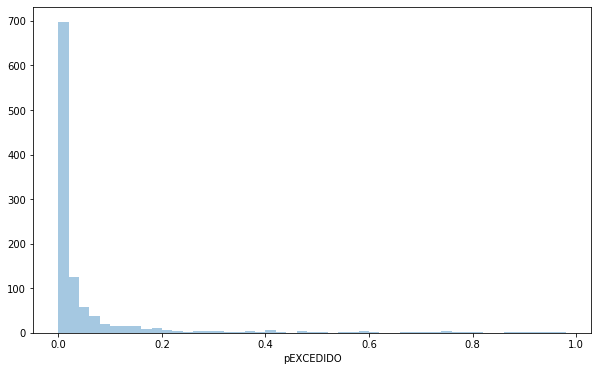

In [68]:
plt.figure(figsize=(10,6))
sns.distplot(dd.pEXCEDIDO, bins=np.arange(0,1,.02), kde=False)

* En la mayoría de los dominios entre 0 y 5% de los envíos excede el máximo definido por el correo

In [52]:
#Verificamos Vendedor
aColumna('SELLER_ID','DT_SELLER')

Atributo: SELLER_ID
Cantegorias: 52437
CAT >= 30  Envios: 1583  Atrib -Total Envíos: 101447 - 0.342350459799207 %
CAT <  30  Envios: 50854  Atrib -Total Envíos: 194878 - 0.657649540200793 % >> OTROS
Envios SIN CAT: 0 -- 0.0 % >> SIN_DATOS
>> A OTROS: 194878 -- 0.657649540200793 %
>> A SIN_DATOS: 0 -- 0.657649540200793 %
----------
Describe >= 30


count    1583.000000
mean       64.085281
std        55.040104
min        30.000000
25%        36.000000
50%        45.000000
75%        69.000000
max       667.000000
Name: SELLER_ID, dtype: float64

----------
CAT más importantes


EXCEDIDO,DT_SELLER,0,1
932,OTROS,186802,8076
1466,XYDSNCU3UV,545,68
354,FPP4RBSNBJ,522,145
1350,W3PZI7S738,517,0
1459,XU025K2P1N,508,38


----------
CAT con Envíos EXCEDIDOS


EXCEDIDO,DT_SELLER,0,1
932,OTROS,186802,8076
354,FPP4RBSNBJ,522,145
986,PUBP0TZYDM,17,104
294,EQV406PHOP,159,91
465,HIIHGPUCI0,4,69
1466,XYDSNCU3UV,545,68
717,LLSLGVF60V,21,60
780,MIJ6Z3ZKQA,371,57
1387,WNONXTQLP7,115,55
735,LU24N9N4PG,79,55


----------


OTROS         0.657650
FPP4RBSNBJ    0.002251
XYDSNCU3UV    0.002069
XU025K2P1N    0.001843
W3PZI7S738    0.001745
Name: DT_SELLER, dtype: float64

::::::::::::::::::::::::::::::


#### Vendedor
* Agrupamos los vendedores con pocos envíos en Otros, representan el 65% de los casos
* El resto lo dejamos separado para poder considerar su comportamiento en la estimación

#### Marca y Modelo. 
* Son descripciones extraídas del JSON
* Se pasa a mayúsculas y se quitan espacios y puntuaciones tranando de unificar

In [53]:
import re, unicodedata

In [54]:
def aColumnaRev(col,  mnmo=30):
    acol='r'+col
    df[acol]=df[col].str.upper()
    df[acol]=df[acol].str.strip()
    df[acol]=np.where(df[acol]=='NA',np.nan,df[acol])    
    df[acol]=df[acol].apply(lambda x: x.encode('ASCII', 'ignore').decode('UTF8') if type(x)==str else x)
    df[acol]=df[acol].apply(lambda x: '_'.join(re.split(r'\W+', x)) if type(x)==str else x)
    

In [55]:
#Revisamos Marca
aColumnaRev('ATR_BRAND')

In [56]:
df[ (df.ATR_BRAND.str.contains('wagen')) | (df.ATR_BRAND.str.contains('WAGEN')) ].ATR_BRAND.value_counts()

Volkswagen                                                                  1717
volkswagen                                                                    24
VOLKSWAGEN                                                                    22
Original Volkswagen                                                            9
ORIGINAL VOLKSWAGEN                                                            3
ORIGINAL - VOLKSWAGEN                                                          2
Nacional Volkswagen                                                            2
Emblema Volkwagen                                                              2
BMW Mercedes Benz Audi Porsche Volkswagen Chevrolet Hyundai Honda Toyota       2
Volkswagen Trw                                                                 2
Original Volkswagen / Perfect                                                  1
VW VOLKSWAGEN                                                                  1
wolkswagen                  

In [57]:
df[ (df.rATR_BRAND.str.contains('wagen')) | (df.rATR_BRAND.str.contains('WAGEN')) ].rATR_BRAND.value_counts()

VOLKSWAGEN                                                                  1764
ORIGINAL_VOLKSWAGEN                                                           14
EMBLEMA_VOLKWAGEN                                                              2
VOLKSWAGEN_TRW                                                                 2
BMW_MERCEDES_BENZ_AUDI_PORSCHE_VOLKSWAGEN_CHEVROLET_HYUNDAI_HONDA_TOYOTA       2
NACIONAL_VOLKSWAGEN                                                            2
VOLJKSWAGEN                                                                    1
VOLKSWAGEN_E9036922_5U1857501AE                                                1
VW_VOLKSWAGEN                                                                  1
WOLKSWAGEN                                                                     1
VOLKSWAGEN_NEW_BEETLE                                                          1
ORIGINAL_VOLKSWAGEN_PERFECT                                                    1
SIMILAR_VOLKSWAGEN          

In [58]:
aColumna('rATR_BRAND','DT_BRAND')

Atributo: rATR_BRAND
Cantegorias: 35849
CAT >= 30  Envios: 1112  Atrib -Total Envíos: 121932 - 0.41148063781321187 %
CAT <  30  Envios: 34737  Atrib -Total Envíos: 111720 - 0.37701847633510505 % >> OTROS
Envios SIN CAT: 62673 -- 0.2115008858516831 % >> SIN_DATOS
>> A OTROS: 111720 -- 0.37701847633510505 %
>> A SIN_DATOS: 62673 -- 0.37701847633510505 %
----------
Describe >= 30


count    1112.000000
mean      109.651079
std       281.893537
min        30.000000
25%        37.000000
50%        51.000000
75%        87.000000
max      7107.000000
Name: rATR_BRAND, dtype: float64

----------
CAT más importantes


EXCEDIDO,DT_BRAND,0,1
743,OTROS,106009,5711
920,SIN_DATOS,60809,1864
466,IMPORTADO,6910,197
875,SAMSUNG,3031,43
666,MOTOROLA,1726,1


----------
CAT con Envíos EXCEDIDOS


EXCEDIDO,DT_BRAND,0,1
743,OTROS,106009,5711
920,SIN_DATOS,60809,1864
662,MOR,454,258
183,CHEVROLET,1266,212
466,IMPORTADO,6910,197
1057,VOLKSWAGEN,1574,190
347,FIAT,926,186
602,MARINE_SPORTS,222,166
490,ITAGOLD,13,107
357,FORD,720,102


----------


OTROS         0.377018
SIN_DATOS     0.211501
IMPORTADO     0.023984
SAMSUNG       0.010374
VOLKSWAGEN    0.005953
Name: DT_BRAND, dtype: float64

::::::::::::::::::::::::::::::


#### Marca
* Cerca del 40% de los envíos corresponden a marcas (o descripciones de marcas) con poca relevancia
* El 20% de los envíos NO informa el dato

In [59]:
#Revisamos Modelo
aColumnaRev('ATR_MODEL')

In [60]:
df[ (df.ATR_MODEL.str.contains('romeca')) | (df.ATR_MODEL.str.contains('ROMECA')) ].ATR_MODEL.value_counts()

Chromecast (2nd Generation)    413
Chromecast (1st Generation)     14
Chromecast Ultra                 2
CHROMECAST2                      1
Cromecast 2                      1
Chromecast                       1
Name: ATR_MODEL, dtype: int64

In [61]:
df[ (df.rATR_MODEL.str.contains('romeca')) | (df.rATR_MODEL.str.contains('ROMECA')) ].rATR_MODEL.value_counts()    

CHROMECAST_2ND_GENERATION_    413
CHROMECAST_1ST_GENERATION_     14
CHROMECAST_ULTRA                2
CHROMECAST2                     1
CHROMECAST                      1
CROMECAST_2                     1
Name: rATR_MODEL, dtype: int64

In [62]:
aColumna('rATR_MODEL','DT_MODEL')

Atributo: rATR_MODEL
Cantegorias: 79008
CAT >= 30  Envios: 496  Atrib -Total Envíos: 32387 - 0.10929553699485363 %
CAT <  30  Envios: 78512  Atrib -Total Envíos: 158002 - 0.5332050957563486 % >> OTROS
Envios SIN CAT: 105936 -- 0.3574993672487978 % >> SIN_DATOS
>> A OTROS: 158002 -- 0.5332050957563486 %
>> A SIN_DATOS: 105936 -- 0.5332050957563486 %
----------
Describe >= 30


count    496.000000
mean      65.296371
std       57.947546
min       30.000000
25%       36.000000
50%       46.000000
75%       69.250000
max      609.000000
Name: rATR_MODEL, dtype: float64

----------
CAT más importantes


EXCEDIDO,DT_MODEL,0,1
318,OTROS,149478,8524
409,SIN_DATOS,102433,3503
470,UNIVERSAL,599,10
411,SLIM,414,74
115,CHROMECAST_2ND_GENERATION_,413,0


----------
CAT con Envíos EXCEDIDOS


EXCEDIDO,DT_MODEL,0,1
318,OTROS,149478,8524
409,SIN_DATOS,102433,3503
177,EVA_DE_ENCAIXE,91,79
411,SLIM,414,74
92,BULBO,125,40
165,EA131,0,38
355,PRETO_COM_CAPPUCCINO,0,33
429,STROLL,0,30
211,GRADE,16,29
152,DIANTEIRO,26,27


----------


OTROS                         0.533205
SIN_DATOS                     0.357499
UNIVERSAL                     0.002055
SLIM                          0.001647
CHROMECAST_2ND_GENERATION_    0.001394
Name: DT_MODEL, dtype: float64

::::::::::::::::::::::::::::::


#### Modelo
* Más del 50% de los envíos corresponden a modelos (o descripciones de modelos) con poca relevancia
* El 35% de los envíos NO informa el dato

In [63]:
#Verifico Status
pd.crosstab(index=df.STATUS, columns=df.EXCEDIDO)

EXCEDIDO,0,1
STATUS,,
active,154465,7037
closed,16892,1550
inactive,2975,51
paused,78228,3968
under_review,30454,705


In [64]:
#Verifico Precio
print(df.PRICE.describe())
display(df[ df.PRICE < df.PRICE.std()*2 ].PRICE.max())
display(df[ df.PRICE > df.PRICE.std()*2 ].sample(5))

count    2.619580e+05
mean     1.610124e+03
std      5.952876e+05
min      1.000000e-01
25%      4.890000e+01
50%      1.000000e+02
75%      1.790000e+02
max      3.032487e+08
Name: PRICE, dtype: float64


300349.5

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,...,ATR_CONDITION,EXCEDIDO,DT_CAT_PROD,DT_CONDITION,DT_DOMAIN,DT_SELLER,rATR_BRAND,DT_BRAND,rATR_MODEL,DT_MODEL
127285,I9TISYQF6N,135.0,21.0,15.0,15.0,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-PARTY_HEADBANDS_CROWNS_AND_TIARAS,1.200000e+07,...,Novo,0,H53U1H7Q5G,new,OTROS,OTROS,NaN,SIN_DATOS,NaN,SIN_DATOS
255554,G1OHIWJGQC,110.0,16.0,11.0,2.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-FOOTBALL_KITS,3.032487e+08,...,Novo,0,H53U1H7Q5G,new,OTROS,OTROS,OUTROS,OUTROS,INFANTIL,INFANTIL
146015,OKL42EOXRF,100.0,15.8,11.5,4.1,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-AUTOMOTIVE_IGNITION_KEYS,5.000000e+06,...,Novo,0,H53U1H7Q5G,new,MLB-AUTOMOTIVE_IGNITION_KEYS,DV9ASD6WSO,ORIGINAL,ORIGINAL,NaN,SIN_DATOS
249477,A6AL4636G8,109.0,18.0,13.0,12.0,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-PARTY_HEADBANDS_CROWNS_AND_TIARAS,1.200000e+07,...,Novo,0,H53U1H7Q5G,new,OTROS,OTROS,NaN,SIN_DATOS,NaN,SIN_DATOS
99140,DQIDFDW0DO,1400.0,55.0,35.0,35.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-QUILTS_AND_COVERLETS,5.609428e+06,...,Novo,0,H53U1H7Q5G,new,MLB-QUILTS_AND_COVERLETS,OTROS,J_F_SHOPP,OTROS,URSO,OTROS


In [65]:
df[ df.PRICE > 30000 ].sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,...,ATR_CONDITION,EXCEDIDO,DT_CAT_PROD,DT_CONDITION,DT_DOMAIN,DT_SELLER,rATR_BRAND,DT_BRAND,rATR_MODEL,DT_MODEL
194644,OUY8FD7YOC,39.0,0.0,0.0,0.0,"[{'id': 'AREA_MEASUREMENT', 'name': 'Cálculo d...",H53U1H7Q5G,new,MLB-TAPE_MEASURES,247719.45,...,Novo,0,H53U1H7Q5G,new,OTROS,OTROS,ASTRO,OTROS,URSO,OTROS
394472,SRFCWOA28Z,2820.0,16.0,11.0,4.0,"[{'id': 'WHEELS_NUMBER', 'name': 'Quantidade d...",H53U1H7Q5G,new,MLB-SUITCASES,99999.00,...,Novo,0,H53U1H7Q5G,new,MLB-SUITCASES,YSSX9W9ZGU,IMPORTADO,IMPORTADO,MALA_NOVA,OTROS
164642,R2MLJ9MTSU,1460.0,42.0,26.0,6.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-LEARNING_TOY_LAPTOPS,99999.00,...,Novo,0,H53U1H7Q5G,new,MLB-LEARNING_TOY_LAPTOPS,OTROS,CARTOON_NETWORK,OTROS,LAPTOP_BEN_10,OTROS
332321,TKICTMNTM0,3200.0,16.0,11.0,4.0,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-INDOOR_CURTAINS_AND_BLINDS,100169.90,...,Novo,0,H53U1H7Q5G,new,MLB-INDOOR_CURTAINS_AND_BLINDS,OTROS,NaN,SIN_DATOS,NaN,SIN_DATOS
14999,VW686ZC636,335.0,35.0,29.0,4.0,"[{'id': 'ALPHANUMERIC_MODEL', 'name': 'Modelo ...",F3LSYRQWQ8,new,MLB-HEADPHONES,50000.00,...,Novo,0,OTROS,new,MLB-HEADPHONES,RMZRQWMIVD,JBL,JBL,500BT,OTROS


In [69]:
pd.crosstab(index=df[ df.PRICE>30000].DT_DOMAIN, columns=df[ df.PRICE>30000].EXCEDIDO)

EXCEDIDO,0
DT_DOMAIN,
MLB-AIRSOFT_GUNS,1
MLB-AUDIO_INTERFACES,1
MLB-AUTOMOTIVE_IGNITION_KEYS,1
MLB-BOOKS,1
MLB-CELLPHONES,1
MLB-CELLPHONE_AND_TABLET_SCREEN_PROTECTORS,1
MLB-CONCEALERS,1
MLB-ELECTRONIC_PRODUCTS,1
MLB-GEL_NAIL_KITS,2


In [70]:
#Eliminamos precios > 30mil reales por ser aparentemente inválidos y además NO estuvieron excedidos en dimensiones
df_hprice=df[ df.PRICE> 30000]
df.drop(df_hprice.index, axis=0, inplace=True)
print(df_hprice.shape)
print(df.shape)

(34, 28)
(296291, 28)


#### Precio
* Eliminamos precios > 30mil reales por ser aparentemente inválidos y además NO estuvieron excedidos en dimensiones


In [71]:
#Exporto dataset revisado
columnas=['ITEM_ID', 'SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT',
       'PRICE', 'STATUS', 'TITLE', 'LEN_ATR', 'DT_CAT_PROD', 'DT_CONDITION',
       'DT_DOMAIN', 'DT_SELLER', 'DT_BRAND', 'DT_MODEL', 'EXCEDIDO']

In [72]:
df[columnas].to_csv('dataset/meli_dataset_a.csv', index=False)